In [ ]:
!rm -rf ./ML4CV_XAI
!git clone https://github.com/liuktc/ML4CV_XAI.git
!pip install captum grad_cam torcheval
%load_ext autoreload

%autoreload 2

import sys
sys.path.append('/kaggle/working/ML4CV_XAI')

Cloning into 'ML4CV_XAI'...
remote: Enumerating objects: 818, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 818 (delta 6), reused 19 (delta 5), pack-reused 789 (from 1)
Receiving objects: 100% (818/818), 63.56 MiB | 39.13 MiB/s, done.
Resolving deltas: 100% (359/359), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 38.5 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 31.2 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 12.2 MB/s eta 0:00:00
  Created wheel for grad_cam: filename=grad_cam-1.5.4-py3-none-any.whl size=39680 sha256=0a68309590a3edf4e79646b401573e3d306ac48f301b6b3a2c46364d5a4b2a7a
  Stored in directory: /root/.cache/pip/wheels/50/b0/82/1f97b5348c7fe9f0ce0ba18497202cafa5dec4562bd5292680
Successf

In [15]:
%load_ext autoreload

%autoreload 2

import numpy as np
import torch
from torch.utils.data import DataLoader

from utils import _DeepLiftShap, _GradCAMPlusPlus, SimpleUpsampling,ERFUpsamplingFast, min_max_normalize
from data import imagenettewoof, SynteticFigures
from results.results_metrics import ResultMetrics
from models import resnet18_Imagenettewoof, resnet_preprocess, resnet50_Imagenettewoof

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
torch.manual_seed(123)
np.random.seed(123)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
model = resnet50_Imagenettewoof()
# model = vgg11_Syntetic()
model.to(device)
# Load the pretrained weights
# model.load_state_dict(torch.load('./VGG11_Imagenettewoof.pth', map_location=device))
# model.load_state_dict(torch.load('./VGG11_Synthetic.pt', map_location=device))
model.eval()

preprocess = resnet_preprocess

c:\Users\Luca\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\Luca/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:04<00:00, 25.0MB/s]


In [17]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [18]:
train_data = imagenettewoof(split="train",size="320px",download=False, transform=preprocess)
test_data = imagenettewoof(split="test",size="320px", download=False, transform=preprocess)
# from data import SynteticFigures, BlurImagePerlinNoise, Binarize
# import torchvision.transforms as transforms
# from torchvision.transforms import InterpolationMode
# from models import vgg_preprocess

# TRAIN_SIZE = 8
# TEST_SIZE = 6 * 50
# BATCH_SIZE = 1



# background_transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomVerticalFlip(),
#     transforms.ColorJitter(brightness=0.25, contrast=0.15, saturation=0.15, hue=0.15),
# ])

# mask_preprocess = transforms.Compose([
#         transforms.Resize((224, 224), interpolation=InterpolationMode.NEAREST),
#         transforms.GaussianBlur(kernel_size=15),
#         transforms.ToTensor(),  # Convert to Tensor
#         Binarize(),
# ])

# train_transform = transforms.Compose([
#     transforms.Resize((224,224)),
#     # transforms.RandomResizedCrop(224),        # Random crop + resize
#     transforms.RandomHorizontalFlip(),        # Random flip
#     transforms.ColorJitter(0.3, 0.3, 0.3),    # Color variations
#     transforms.RandomRotation(15),            # Slight rotation
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

# train_data = SynteticFigures(background_path="./data/WaldoNoise",
#                             num_images=TRAIN_SIZE,
#                             split='train',
#                             num_shapes_per_image=1,
#                             image_transform=train_transform,
#                             background_transform=background_transform,
#                             mask_preprocess=mask_preprocess,
#                             size_range=(80, 100))

# test_data = SynteticFigures(background_path="./data/WaldoNoise",
#                             num_images=TEST_SIZE,
#                             split='test',
#                             num_shapes_per_image=1,
#                             image_transform=vgg_preprocess,
#                             background_transform=background_transform,
#                             mask_preprocess=mask_preprocess,
#                             size_range=(80, 100))

data\imagewoof2-320
data\imagewoof2-320


In [19]:
###########################################
###########################################
###########################################
###########################################
## TO CHANGE IN KAGGLE
INDEX = 0 # 0,1,2,3
###########################################
###########################################
###########################################
###########################################

# Number of parts to split the dataset into
num_parts = 2

# Get the total number of images in the dataset
total_size = len(test_data)

# Split the dataset indices into roughly equal parts
split_indices = np.array_split(np.arange(total_size), num_parts)

INDICES = split_indices[INDEX]

In [20]:
import torch.utils
from torch.utils.data import Subset

# BATCH_SIZE_TEST = 1

BATCH_SIZE_TRAIN = 2
NUM_TRAIN = 16

# dl_test = DataLoader(test_data, batch_size=BATCH_SIZE_TEST, shuffle=False)
dl_train = DataLoader(Subset(train_data, torch.randperm(len(train_data))[:NUM_TRAIN]), batch_size=BATCH_SIZE_TRAIN, shuffle=False)

In [21]:
baseline_dist_16 = torch.cat([images for images,  _ in dl_train], dim=0).to(device)
baseline_dist_8 = baseline_dist_16[:8].clone()
baseline_dist_4 = baseline_dist_16[:4].clone()

In [22]:
# LAYERS = [20,15,10,5]
layers = [model.layer4, model.layer3, model.layer2, model.layer1]

Results loaded from ./results_mixed_synth_0.csv.
torch.Size([1, 1, 7, 7])


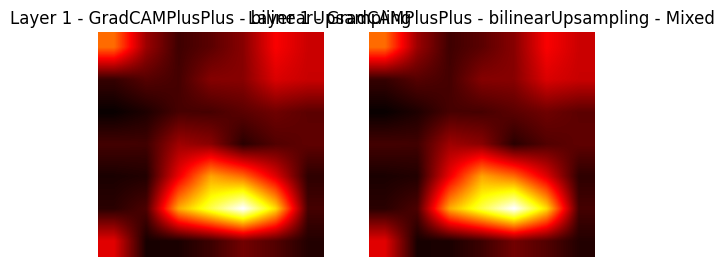

torch.Size([1, 1, 14, 14])


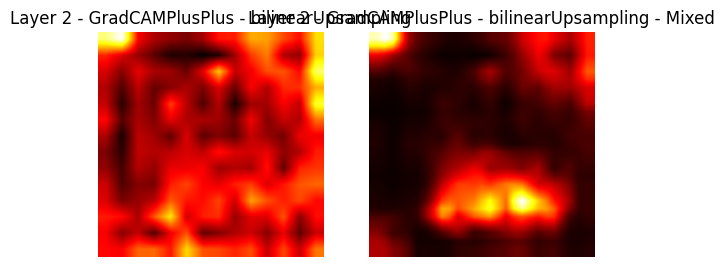

torch.Size([1, 1, 28, 28])


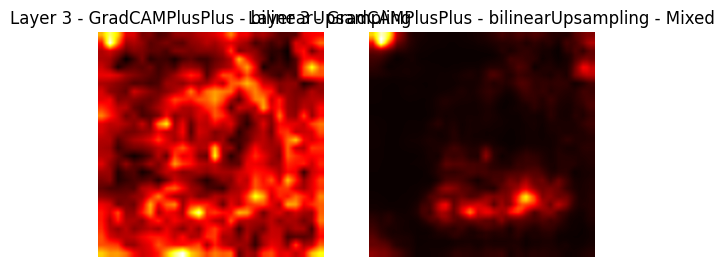

torch.Size([1, 1, 56, 56])


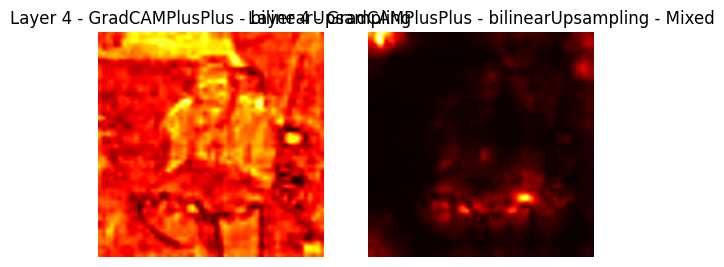

In [23]:
from metrics import RoadCombined, AverageDrop, InsertionCurveAUC, DeletionCurveAUC, Coherency, Complexity, Infidelity, ROC_AUC
from utils import MultiplierMix, _ScoreCAM, _EigenCAM, _LayerCAM, IdentityMix, _ShapleyCAM
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

results = ResultMetrics("./results_mixed_synth_0.csv")

last_image_index = results.get_last_image_index()

# for index in tqdm(INDICES[1:]):
for index in [5]:
    if index < last_image_index:
        continue
    if len(test_data[index]) == 2:
        images, labels = test_data[index]
        mask = None
    elif len(test_data[index]) == 3:
        images, mask, labels = test_data[index]
        mask = mask.unsqueeze(0)
    else:
        raise ValueError("Invalid number of elements in test_data[index]")

    images = images.unsqueeze(0)  # Add batch dimension
    labels = torch.Tensor([labels]).long()  # Convert to long tensor    
    images = images.to(device)
    labels = labels.to(device).reshape(-1)

    predicted_label = model(images).argmax(dim=1)

    # Make sure that LAYERS is sorted in descending order
    # LAYERS.sort(reverse=True)
    for  attribution_method in [_GradCAMPlusPlus()]:
    # for attribution_method in [_ShapleyCAM()]:
    # for attribution_method in [_ScoreCAM(), _EigenCAM(), _LayerCAM(), _GradCAMPlusPlus()]:
        # for upsample_method in [ERFUpsamplingFast(), SimpleUpsampling((224,224))]:
        for upsample_method in [SimpleUpsampling((224,224))]:
            attributions_per_layer = []
            for layer_index, layer in enumerate(layers):
            # for layer_index in LAYERS:
                # layer = model.features[layer_index]
                attribution_map = attribution_method.attribute(input_tensor=images,
                                                                model=model,
                                                                layer=layer,
                                                                target=labels
                                                                )
                print(attribution_map.shape)
                # assert(False)
                # upsample_method = SimpleUpsampling((224,224))
                
                
                attribution_map = upsample_method(attribution=attribution_map,
                                                  image=images,
                                                  device=device,
                                                  model=model,
                                                  layer=layer)

                if (torch.abs(
                    attribution_map.amax(dim=(2, 3), keepdim=True)
                    - attribution_map.amin(dim=(2, 3), keepdim=True)
                )
                < 1e-6  ).any():
                    print("A saliency map is constant, skipping batch")
                    del images, labels, attribution_map
                    torch.cuda.empty_cache()
                    continue

                attribution_map = min_max_normalize(attribution_map)
                attributions_per_layer.append(attribution_map)

                # Mix the attribution maps
                mix = MultiplierMix(layers_to_combine="all")
                mixed_attribution_map = mix(attributions_per_layer)
                mixed_attribution_map = min_max_normalize(mixed_attribution_map)

                plt.subplot(1, 2, 1)
                plt.imshow(attribution_map[0, 0].cpu().detach().numpy(), cmap='hot')
                plt.title(f"Layer {layer_index+1} - {attribution_method.name} - {upsample_method.name}")
                plt.axis('off')
                plt.subplot(1, 2, 2)
                plt.imshow(mixed_attribution_map[0, 0].cpu().detach().numpy(), cmap='hot')
                plt.title(f"Layer {layer_index+1} - {attribution_method.name} - {upsample_method.name} - Mixed")
                plt.axis('off')
                plt.show()
                continue
                
                for metric in [ROC_AUC(), DeletionCurveAUC(), InsertionCurveAUC(), Infidelity(), AverageDrop(), Coherency(), Complexity()]:
                    metric_result_normal = metric(model=model,
                            test_images=images,
                            saliency_maps=attribution_map,
                            class_idx=labels,
                            attribution_method=attribution_method,
                            device=device,
                            layer=layer,
                            upsample_method=upsample_method,
                            mixer=IdentityMix(),
                            previous_attributions=attributions_per_layer[:-1],
                            mask=mask)

                    if type(metric_result_normal) is torch.Tensor:
                        metric_result_normal = metric_result_normal.item()
                    
                    results.add_result(model="VGG11",
                                       attribution_method=attribution_method.name,
                                       dataset="Synthetic",
                                       layer=f"model.layer{layer_index+1}",
                                       metric=metric.name,
                                       upscale_method=upsample_method.name,
                                       mixing_method= "None",
                                       value=metric_result_normal,
                                       image_index=index,
                                       label=labels[0].item(),
                                       predicted_label=predicted_label[0].item())

                    metric_result_mixed = metric(model=model,
                            test_images=images,
                            saliency_maps=mixed_attribution_map,
                            class_idx=labels,
                            attribution_method=attribution_method,
                            device=device,
                            layer=layer,
                            upsample_method=upsample_method,
                            mixer=mix,
                            previous_attributions=attributions_per_layer[:-1],
                            mask=mask)

                    if type(metric_result_mixed) is torch.Tensor:
                        metric_result_mixed = metric_result_mixed.item()
                    
                    
                    results.add_result(model="VGG11",
                                       attribution_method=attribution_method.name,
                                       dataset="Synthetic",
                                       layer=f"model.layer{layer_index+1}",
                                       metric=metric.name,
                                       upscale_method=upsample_method.name,
                                       mixing_method= mix.name,
                                       value=metric_result_mixed,
                                       image_index=index,
                                       label=labels[0].item(),
                                       predicted_label=predicted_label[0].item())

results.save_results()

In [48]:
results.results

,Image Index,Label,Predicted Label,Model,Dataset,Attribution Method,Layer,Metric,Upscale Method,Mixing Method,Value
0,140,5,0,VGG11,Imagenettewoof,LayerCAM,features.20,coherency,bilinearUpsampling,IdentityMix,0.957192
1,140,5,0,VGG11,Imagenettewoof,LayerCAM,features.20,coherency,bilinearUpsampling,MultiplierMix,0.957192
2,140,5,0,VGG11,Imagenettewoof,LayerCAM,features.15,coherency,bilinearUpsampling,IdentityMix,0.971222
3,140,5,0,VGG11,Imagenettewoof,LayerCAM,features.15,coherency,bilinearUpsampling,MultiplierMix,0.973306
4,140,5,0,VGG11,Imagenettewoof,LayerCAM,features.10,coherency,bilinearUpsampling,IdentityMix,0.965868
5,140,5,0,VGG11,Imagenettewoof,LayerCAM,features.10,coherency,bilinearUpsampling,MultiplierMix,0.977751
6,140,5,0,VGG11,Imagenettewoof,LayerCAM,features.5,coherency,bilinearUpsampling,IdentityMix,0.951235
7,140,5,0,VGG11,Imagenettewoof,LayerCAM,features.5,coherency,bilinearUpsampling,MultiplierMix,0.953784
